# 집 값 예측 프로젝트     

#### 루브릭 
1. 캐글 데이터분석 전과정이 성공적으로 진행되었는가?
데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 만든 csv파일을 캐글 My submission까지 진행했고, submission 결과를 이미지로 제출하였다.

2. 전처리, 학습과정 및 결과에 대한 설명이 시각화를 포함하여 체계적으로 진행되었는가?
제출한 주피터노트북 파일이 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었다.

3. 회귀모델 예측정확도가 기준 이상 높게 나왔는가?
다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었다. 

In [411]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

print('부동산왕 동기화 중..')

부동산왕 동기화 중..


In [412]:
# 7-4 이거 필요한가?

# import matplotlib.pyplot as plt
# %matplotlib inline  예전 버전 주피터에서 필요, vs code에서는 필요할수도 
# %config InlineBackend.figure_format = 'retina'  해상도

In [413]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)

/aiffel/aiffel/kaggle_kakr_housing/data/train.csv
/aiffel/aiffel/kaggle_kakr_housing/data/test.csv


In [414]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. **price : 타겟 변수인 집의 가격**
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [415]:
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (21503, 19)
sub data dim : (6468, 19)


#### train은 15035개, test는 6468개의 데이터, test에는 target인 price가 빠져 컬럼 개수가 하나 적다.

In [416]:
train

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,15030,20141014T000000,610685.0,4,2.50,2520,6023,2.0,0,0,...,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,15031,20150326T000000,1007500.0,4,3.50,3510,7200,2.0,0,0,...,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,15032,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,15033,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


In [417]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

In [418]:
test

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,21498,20140626T000000,3,1.75,1500,11968,1.0,0,0,3,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303
6464,21499,20150126T000000,3,2.00,1490,1126,3.0,0,0,3,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
6465,21500,20150219T000000,3,2.50,1310,1294,2.0,0,0,3,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265
6466,21501,20140623T000000,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007


In [419]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6468 entries, 0 to 6467
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             6468 non-null   int64  
 1   date           6468 non-null   object 
 2   bedrooms       6468 non-null   int64  
 3   bathrooms      6468 non-null   float64
 4   sqft_living    6468 non-null   int64  
 5   sqft_lot       6468 non-null   int64  
 6   floors         6468 non-null   float64
 7   waterfront     6468 non-null   int64  
 8   view           6468 non-null   int64  
 9   condition      6468 non-null   int64  
 10  grade          6468 non-null   int64  
 11  sqft_above     6468 non-null   int64  
 12  sqft_basement  6468 non-null   int64  
 13  yr_built       6468 non-null   int64  
 14  yr_renovated   6468 non-null   int64  
 15  zipcode        6468 non-null   int64  
 16  lat            6468 non-null   float64
 17  long           6468 non-null   float64
 18  sqft_liv

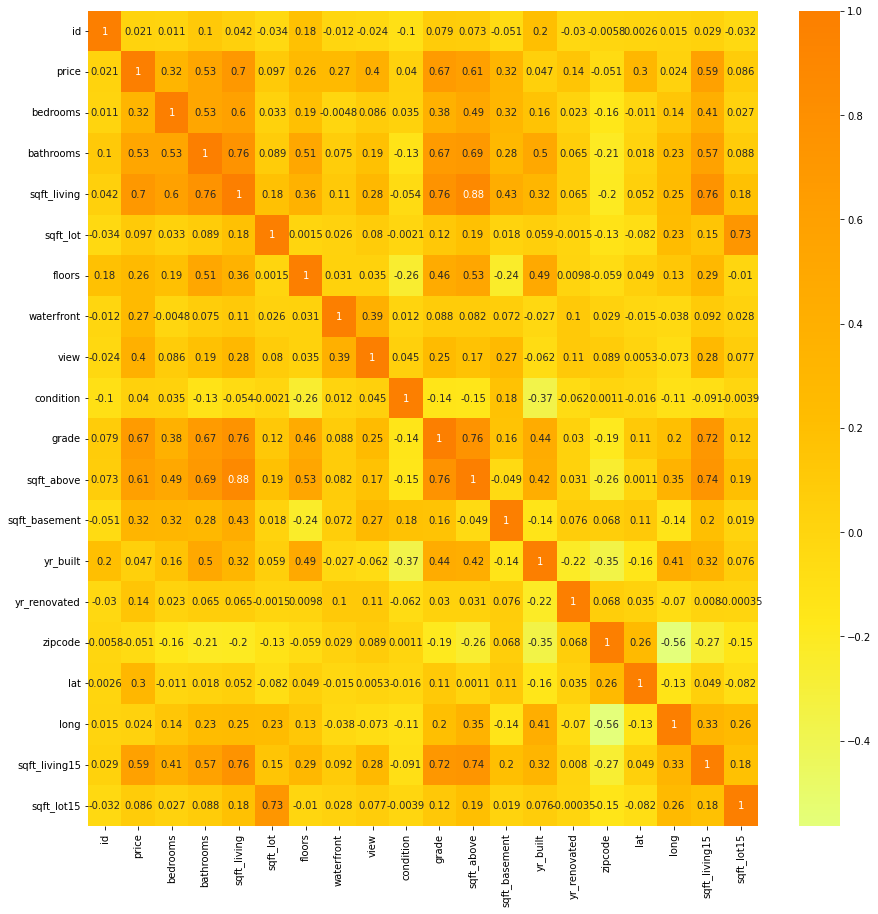

In [420]:
fig, ax = plt.subplots(figsize=(15,15))     

sns.heatmap(train.corr(), annot = True, cmap = 'Wistia')
plt.show()

#### price와의 상관계수의 절댓값이 0.5 이상인 컬럼으로는 sqft_living, bathrooms, grade, sqft_above, sqft_living15이 있다. 

In [421]:
y = train['price']

del train['price']

In [422]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

<AxesSubplot:>

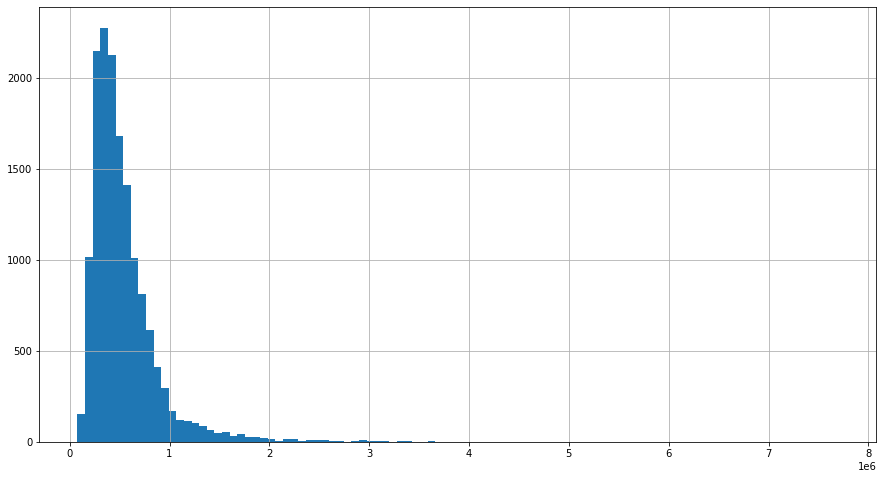

In [423]:
y.hist(bins=100, figsize=(15,8))

#### 히스토그램으로 price의 분포를 보면, 집값이 특정 값에 집중적으로 분포하며 그 이상의 가격에서는 분포가 완만하게 감소하고 있다. 

In [424]:
y.describe()

count    1.503500e+04
mean     5.406827e+05
std      3.715247e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

#### describe를 통해 집값의 평균이 540,682임을 알 수 있다. 
#### 히스토그램의 분포로 보아 price의 최솟값인 78,000 이후로 집의 공급량이 급격히 증가해 평균값 이상에서 완만하게 감소한다.   

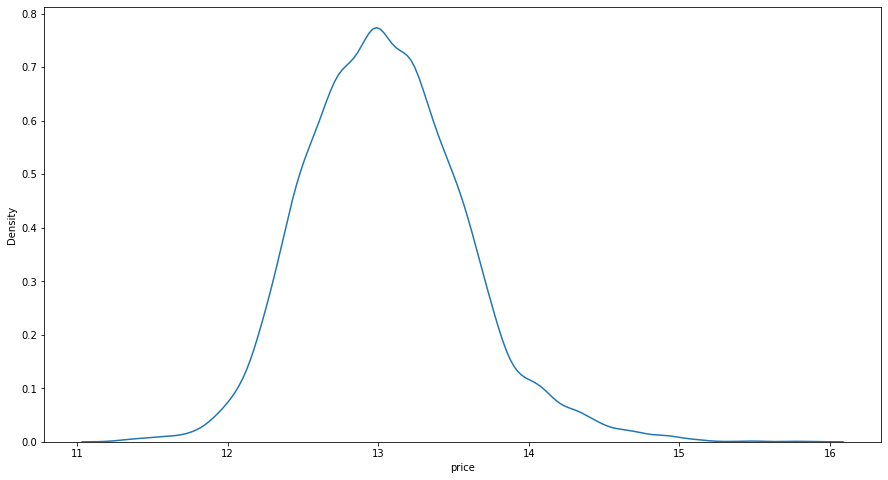

In [425]:
y = np.log1p(y)

fig, ax = plt.subplots(figsize=(15,8))   
sns.kdeplot(y)
plt.show()

#### price에 로그를 취해 KDE plot으로 출력했다. 

In [426]:
train_len = len(train)
train = pd.concat((train, test), axis=0)

#### 모델 학습을 할 때는 train과 test를 다시 분리해야하기 때문에, train_len에 train 데이터의 개수를 저장한다. 

In [427]:
train.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [428]:
print('train data dim : {}'.format(train.shape))

train data dim : (21503, 20)


#### train에서 price 컬럼을 제거하고 test와 합쳐, 데이터는 27,971개, 컬럼은 20개가 되었다.  

## 2. 간단한 전처리 
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다.
### 결측치 확인
먼저 데이터에 결측치가 있는지를 확인하겠습니다.<br>
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

<AxesSubplot:>

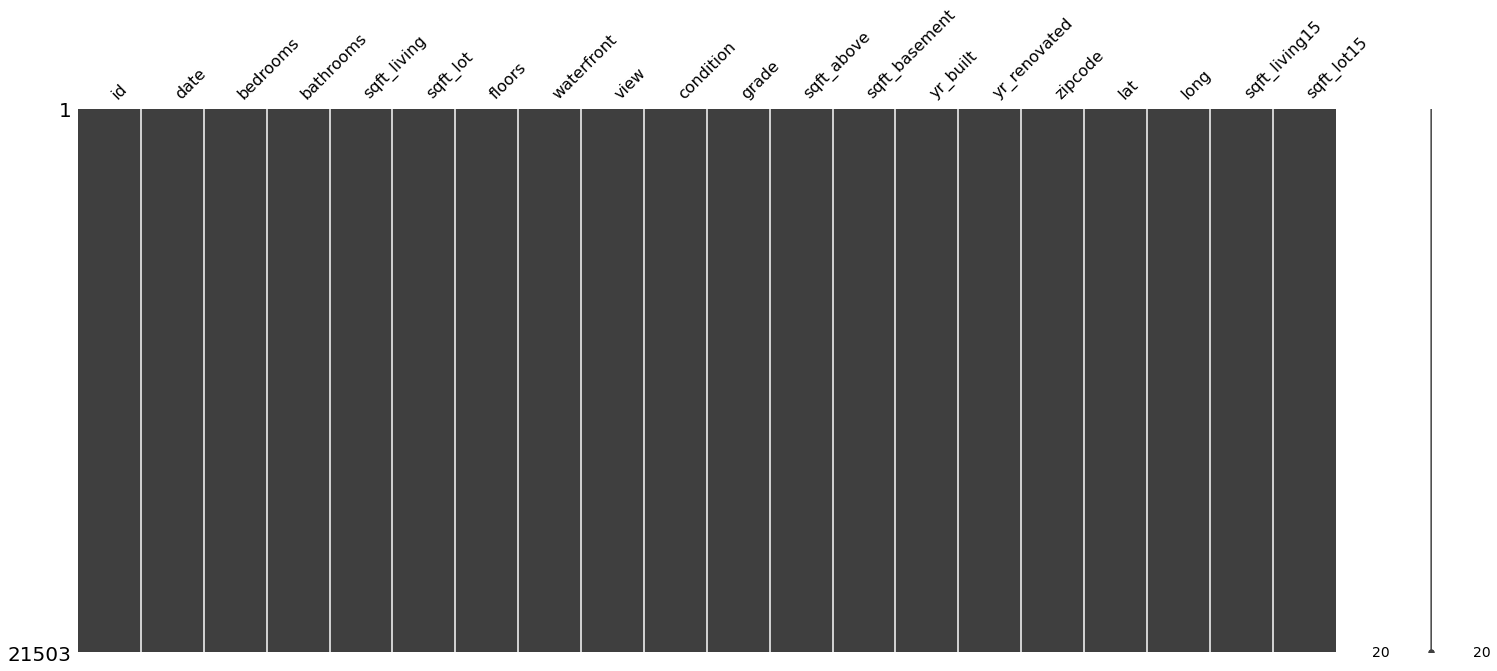

In [429]:
msno.matrix(train)

In [430]:
for c in data.columns:
    print('{} : {}'.format(c, len(train.loc[pd.isnull(train[c]), c].values)))

date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


#### 결측치는 하나도 없다. 

### id, date 변수 정리
id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거합니다.<br>
date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만들겠습니다.

In [431]:
sub_id = train['id'][train_len:]
del train['id']
train['date'] = train['date'].apply(lambda x : str(x[:6])).astype(str)

#### data의 id컬럼 중 train_len 15035개 만큼의 행을 슬라이싱하고 나머지를 sub_id에 저장한다. 

In [432]:
sub_id 

0       15035
1       15036
2       15037
3       15038
4       15039
        ...  
6463    21498
6464    21499
6465    21500
6466    21501
6467    21502
Name: id, Length: 6468, dtype: int64

#### 제출을 대비해 id 컬럼을 sub_id에 따로 저장한다. 

In [433]:
train = train.astype({'date':'int64'})

In [434]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21503 entries, 0 to 6467
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21503 non-null  int64  
 1   bedrooms       21503 non-null  int64  
 2   bathrooms      21503 non-null  float64
 3   sqft_living    21503 non-null  int64  
 4   sqft_lot       21503 non-null  int64  
 5   floors         21503 non-null  float64
 6   waterfront     21503 non-null  int64  
 7   view           21503 non-null  int64  
 8   condition      21503 non-null  int64  
 9   grade          21503 non-null  int64  
 10  sqft_above     21503 non-null  int64  
 11  sqft_basement  21503 non-null  int64  
 12  yr_built       21503 non-null  int64  
 13  yr_renovated   21503 non-null  int64  
 14  zipcode        21503 non-null  int64  
 15  lat            21503 non-null  float64
 16  long           21503 non-null  float64
 17  sqft_living15  21503 non-null  int64  
 18  sqft_lo

#### date 컬럼을 수치형 데이터로 바꿔주었다. 

In [435]:
train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

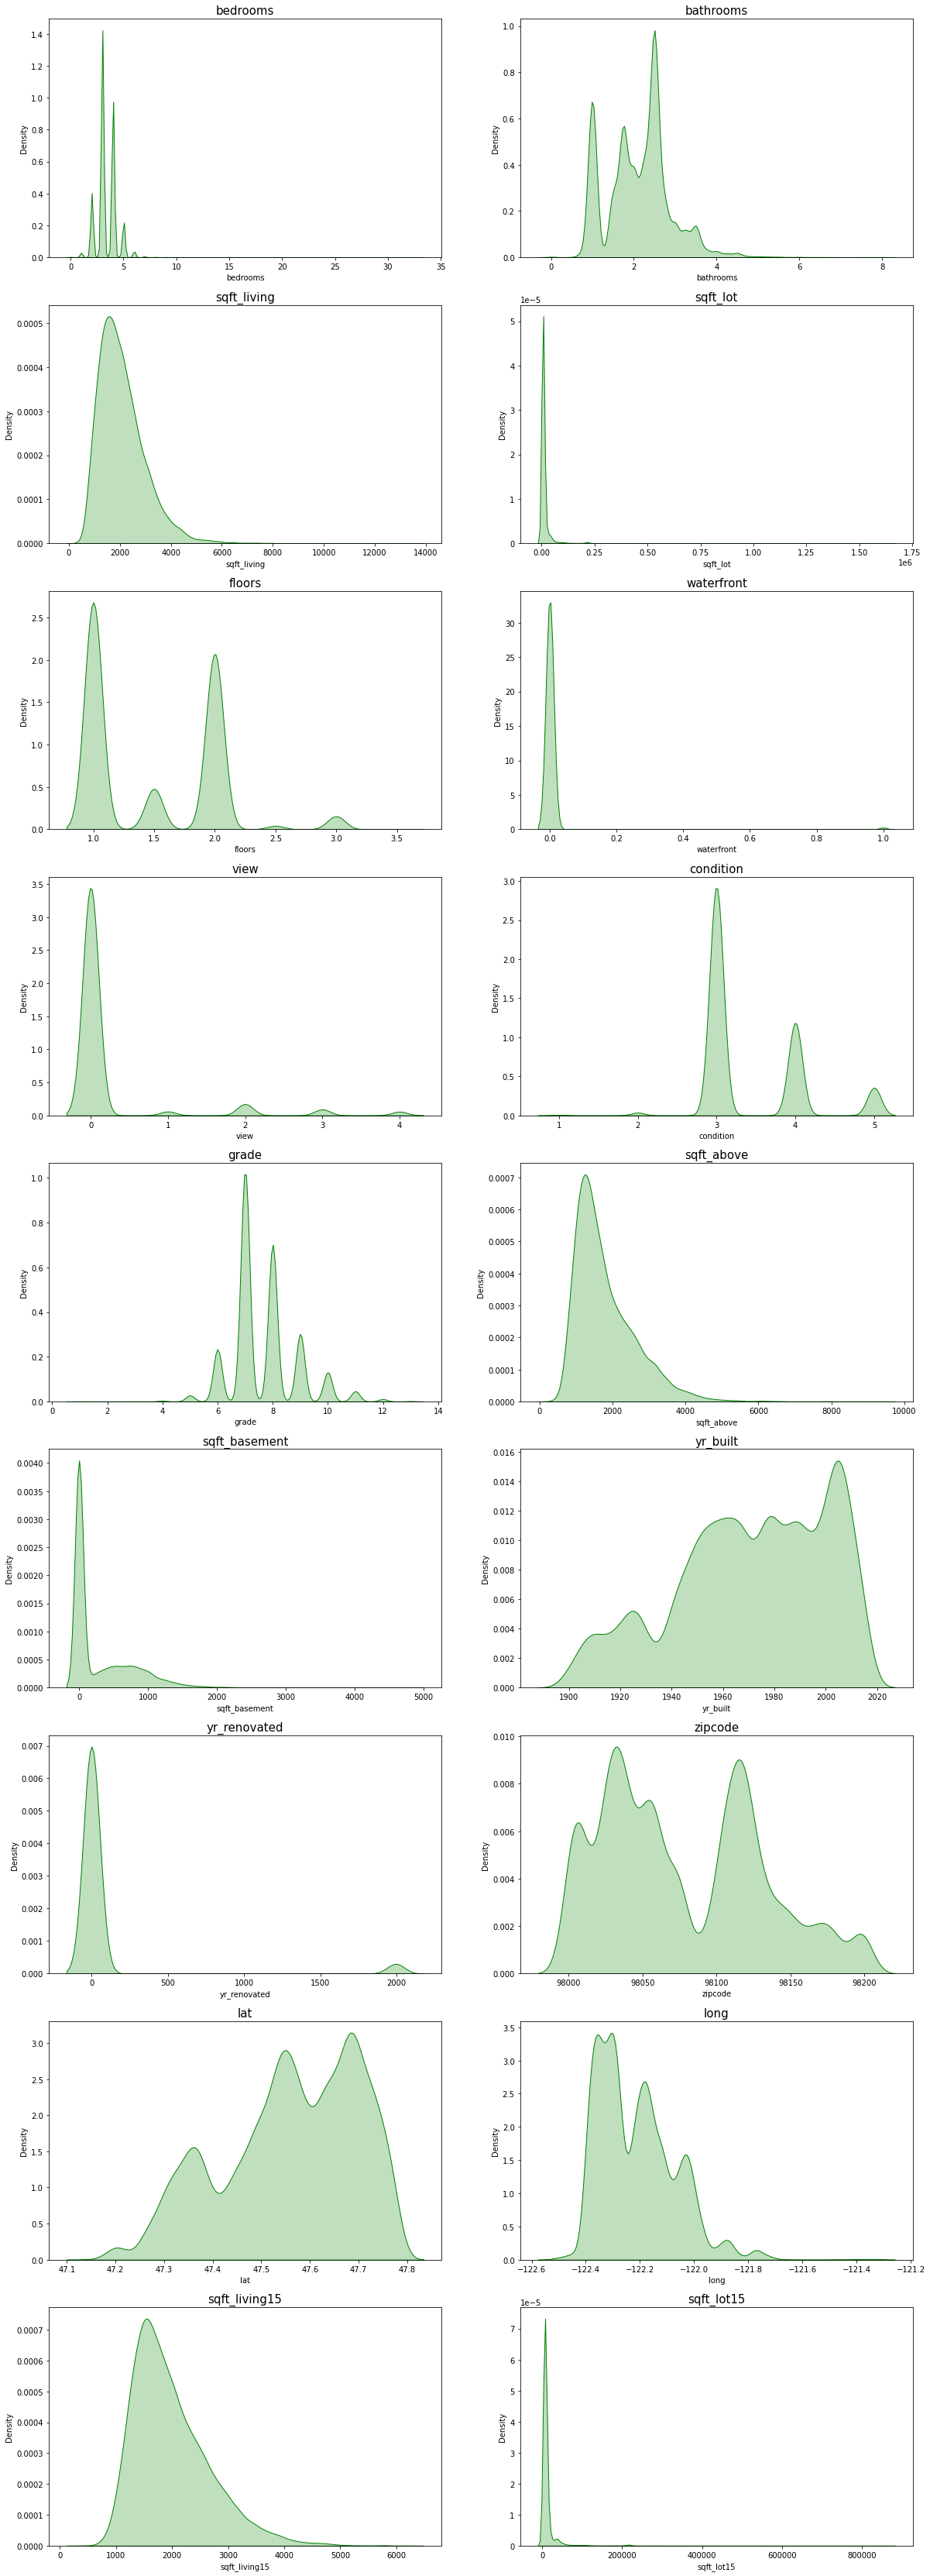

In [436]:
fig, ax = plt.subplots(9, 2, figsize=(20, 60))  # 9행2열의 그래프를 만들어라 

count = 1                    
columns = train.columns  # cloums는 data의 컬럼 19개 
for row in range(9):
    for col in range(2): 
        sns.kdeplot(data=train[columns[count]], ax=ax[row][col], color = 'g', shade=True) # shade=True : 그래프 안 채우기 
        ax[row][col].set_title(columns[count], fontsize=15) # date 제외한 컬럼의 확률밀도함수출력 
        count += 1
        if count == 19 :
            break 

#### KDE plot을 통해 각 컬럼의 확률밀도함수로 분포를 확인할 수 있다.  

#### 베이스라인의 'fig, ax = plt.subplots(10, 2'때문에 에러가 나서 10을 9로 바꿔주었다. 컬럼이 18개라 20개의 그래프를 그릴 수 없어서 그런 것 같다. 

REF)    
https://darkpgmr.tistory.com/147 커널밀도추정(KDE) 그래프란?     
https://hleecaster.com/python-seaborn-kdeplot/ KDE plot 활용 

#### bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement, sqft_lot15 그래프가 한쪽으로 치우친 경향을 보인다. 그래서 log-scaling을 해보았다. 

In [437]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)

print('부동산왕 동기화 중..')

부동산왕 동기화 중..


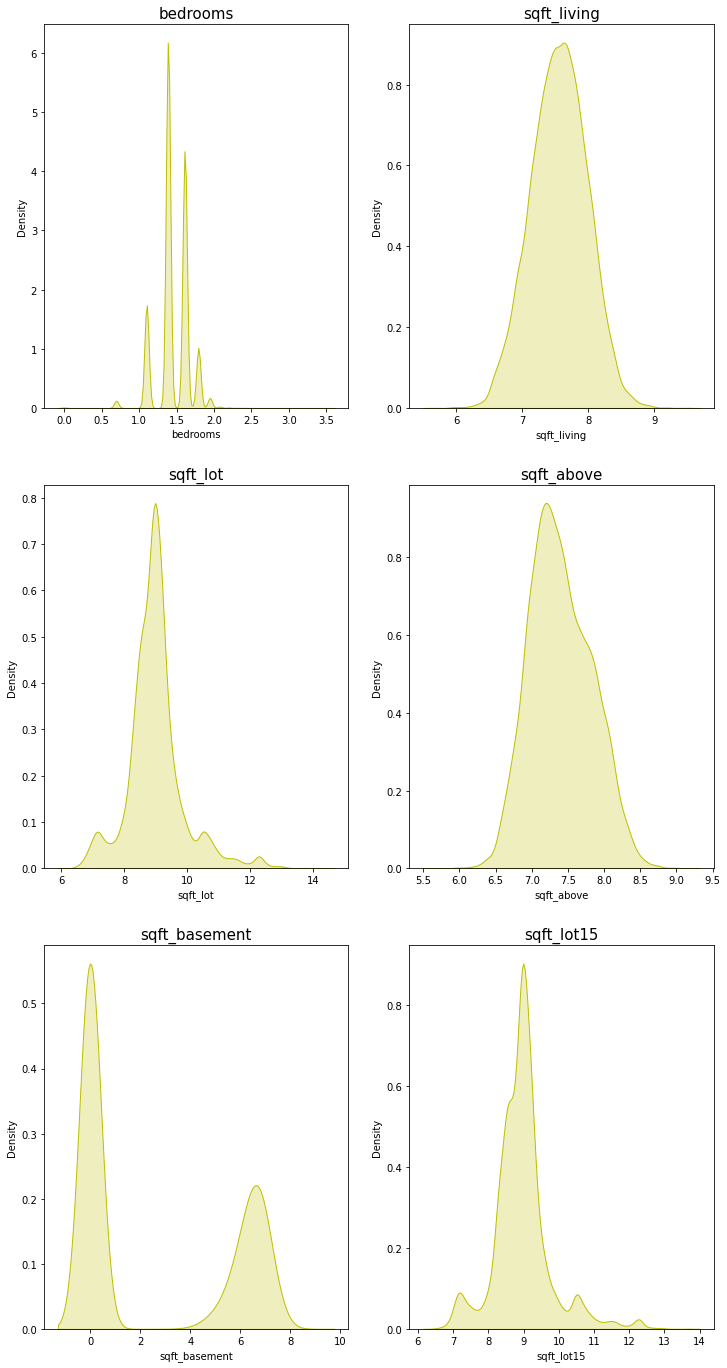

In [438]:
fig, ax = plt.subplots(3, 2, figsize=(12, 24))

count = 0
for row in range(3):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data=train[skew_columns[count]], ax=ax[row][col], color = 'y', shade=True)
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

#### 그래프가 전체적으로 정규분포에 가깝게 변했다. 

In [439]:
test = train.iloc[train_len:, :]
x = train.iloc[:train_len, :]
train = train.iloc[:train_len, :]

#### train_len을 인덱스로 활용해서 :train_len까지는 학습 데이터인 x에 저장하고, train_len: 부터는 실제로 추론을 해야 하는 테스트 데이터인 sub 변수에 저장한다.

## 3. 모델링
### Average Blending
여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들겠습니다.

In [447]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [440]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

### Cross Validation
교차 검증을 통해 모델의 성능을 간단히 평가하겠습니다.

In [441]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=2019, shuffle=True).get_n_splits(x.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], x.values, y)), 
                                             kf=kfold))

In [442]:
get_cv_score(models)

Model GradientBoosting CV score : 0.8796
Model XGBoost CV score : 0.8973
Model LightGBM CV score : 0.9025


#### 3가지 모델의 결정계수가 출력되었다. 그 중 XGBoost가 가장 학습이 잘 되었다.      
#### ValueError: Setting a random_state has no effect since shuffle is False. You should leave random_state to its default (None), or set shuffle=True. 에러가 나와 shuffle=True로 설정해주었다. 

### Make Submission

회귀 모델의 경우에는 cross_val_score 함수가 R<sup>2</sup>를 반환합니다.<br>
R<sup>2</sup> 값이 1에 가까울수록 모델이 데이터를 잘 표현함을 나타냅니다. 3개 트리 모델이 상당히 훈련 데이터에 대해 괜찮은 성능을 보여주고 있습니다.<br> 훈련 데이터셋으로 3개 모델을 학습시키고, Average Blending을 통해 제출 결과를 만들겠습니다.

In [443]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

#### 앙상블 기법 중 averaging을 활용했다. 

In [444]:
y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

6468


array([13.14462881, 12.98192758, 14.08443622, ..., 13.02622152,
       12.72060737, 12.98918701])

In [445]:
from sklearn.metrics import mean_squared_error

RMSE = mean_squared_error(y, y_pred)**0.5

ValueError: Found input variables with inconsistent numbers of samples: [15035, 6468]

#### 베이스라인만으로 Kaggle에 제출했을 때 score가 116129점이 나왔다. 

In [395]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

print('부동산왕 동기화 중..')

부동산왕 동기화 중..


In [397]:
random_state=2020 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

print('부동산왕 동기화 중..')

부동산왕 동기화 중..


In [398]:
from sklearn.model_selection import train_test_split

def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df
    

get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,128360.173766
RandomForestRegressor,125328.289175
LGBMRegressor,111906.947718
XGBRegressor,110319.723794


### 하이퍼 파라미터 튜닝

In [399]:
from sklearn.model_selection import GridSearchCV

print('부동산왕 동기화 중..')

부동산왕 동기화 중..


In [400]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

In [401]:
model = LGBMRegressor(random_state=random_state)

print('부동산왕 동기화 중..')

부동산왕 동기화 중..


In [454]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [456]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027024,0.164388
2,10,50,-0.029173,0.170802
1,1,100,-0.055023,0.234570
0,1,50,-0.073398,0.270920


#### NMSE는 MSE에 음수를 취한 값이므로 0에 가까울수록 좋다. 
#### max_depth = 10, n_estimators = 100이 가장 적합한 파라미터다. 

In [464]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [465]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.164399')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.164399.csv saved!
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.6s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.6s
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.9s
[CV] END .....................max_depth=10, n_estimators=100; total time=   1.7s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.4s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.8s
[CV] END ......................max_depth=10, n_estimators=50; total time=   1.3s
[CV] END .....................max_depth=10, n_estimators=100; total time=   1.9s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.4s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.5s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.6s
[CV] END ..................

## 회고

#### 헤맸던 것
- sub_id = data['id'][train_len:]코드에서 [train_len:]부분이 무슨 의미인지 이해가 안됐다. 퍼실님께 여쭤봐서 해당 부분 만큼은 슬라이싱해 떼어내버린 나머지를 말한다는걸 알았다.  
- 베이스라인과 노드의 코드가 달라 에러나는게 많아서, 고치는데 시간이 걸렸다. 
- train_test_split 할 때, train과 y의 개수가 달라 한참 헤맸다. 퍼실님 도움으로 train에 train_len 만큼의 데이터만 할당해 해결했다. 

#### 새롭게 알게된 것
- info나 insnull외에도 msno.matrix()와 for문을 활용해 결측치를 확인할 수 있다. 

#### 아직도 모르는 것 
- 결측치 확인할 때 isnull().sum()을 쓰지 않고, for문을 쓰는 이유가 뭘까? 같은 결과라도 코드를 짜는 사람마다 선호하는게 달라서 그런가...
